In [13]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ones,vstack
from numpy.linalg import lstsq
from matplotlib import _cntr as cntr
import tensorflow as tf

from data import sample_gmm_2d, graph_data,graph_surface, labels_to_one_hot
from confusion_matrix import get_confusion_matrix
from confusion_matrix import eval_AP
from confusion_matrix import eval_perf_multi

2088
Iteration = 0 Loss = 1.053182
Iteration = 2000 Loss = 0.017445
Iteration = 4000 Loss = 0.016869
Iteration = 6000 Loss = 0.016534
Iteration = 8000 Loss = 0.016256


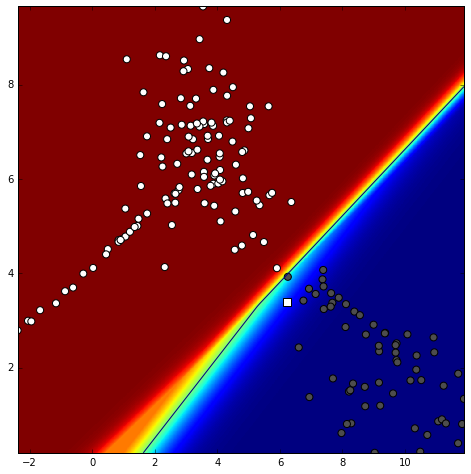

In [2]:
from fcann2 import fcann2_train, predict_c1_class

# seed = 119 0.5 i 10000
#seed = 2519 eo nezz
# seed = 2215 0.01 learning rate 10000 iteracija
# 4700 1416 2612 3836
# seed = np.random.randint(0,5000)
# print seed
np.random.seed(2612)
input_data, expected_output = sample_gmm_2d(6,2,30)

W2, b2, W1, b1 = fcann2_train(input_data, expected_output,learning_rate=0.1)
decfun = predict_c1_class(input_data,W1,b1,W2,b2)

# evaluate the model on the train set
probs = decfun(input_data)

# recover the predicted classes Y
my_predictions = probs >0.5
my_predictions = my_predictions.flatten()


# graph the decision surface
bbox=(np.min(input_data, axis=0), np.max(input_data, axis=0))

#axis limits of the graph
xmin, ymin = bbox[0]
xmax, ymax = bbox[1]
plt.figure(figsize=(8,8))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

graph_surface(decfun, bbox, offset=0.5)

# graph the data points
graph_data(input_data, expected_output, my_predictions)

# show the plot
plt.show()

Iteration = 0, loss = [array([ 0.81685609,  0.05111462,  0.0712094 ,  0.00382487,  0.01114746,
        0.56442863,  0.10559227,  0.79476625,  1.33837748,  2.65094256], dtype=float32)]

Iteration = 100, loss = [array([ 0.02005875,  0.58464199,  0.00230822,  0.000865  ,  0.00071828,
        0.15623356,  0.06487702,  0.00777904,  0.01688605,  0.14257923], dtype=float32)]

Iteration = 200, loss = [array([  5.33577986e-02,   4.55962390e-01,   1.70814525e-03,
         3.59612121e-03,   1.34987086e-02,   9.35600176e-02,
         1.18406534e-01,   1.43718694e-06,   1.64380728e-03,
         8.30531344e-02], dtype=float32)]

Iteration = 300, loss = [array([  6.95435330e-02,   4.12847191e-01,   5.48306946e-03,
         8.59063957e-03,   2.21717991e-02,   7.46151879e-02,
         1.41993701e-01,   1.15035556e-03,   6.12444637e-05,
         6.52656332e-02], dtype=float32)]

Iteration = 400, loss = [array([  7.60032833e-02,   3.97600979e-01,   7.40005542e-03,
         1.09540364e-02,   2.58816611e-0

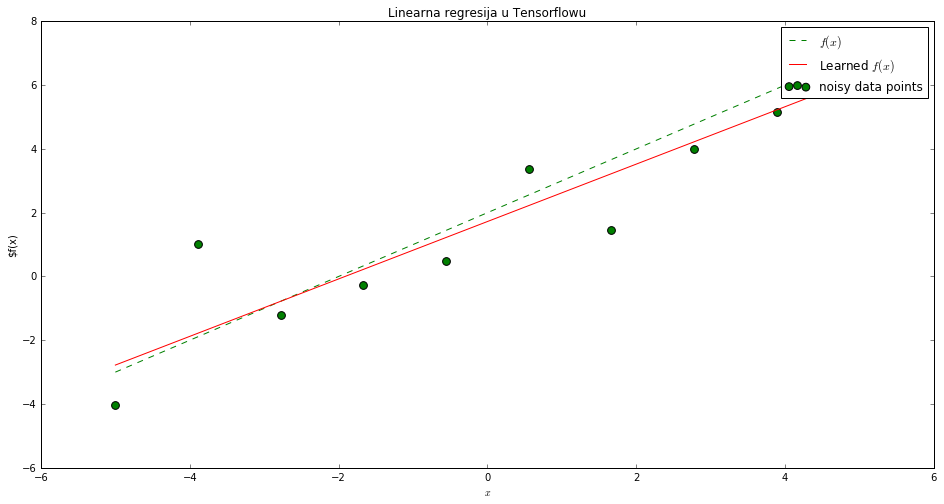

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def f(X):
    return X+2

def make_labels(X,std):
    return f(X) + np.random.normal(scale=std,size=len(X))

N=10
n_iter=1000
print_every = 100
input_data = np.linspace(-5,5,N)
output_data = make_labels(input_data,1)
analythic_grad = False
## 1. definicija računskog grafa
# podatci i parametri
X  = tf.placeholder(tf.float32, [None])
Y_ = tf.placeholder(tf.float32, [None])
a = tf.Variable(0.0)
b = tf.Variable(0.0)

polovina = tf.constant(0.5,tf.float32)

# afini regresijski model
Y = a * X + b

# kvadratni gubitak  * 0.5 da se derivacijom rijesi ova polovina i bude better
loss = polovina* (Y-Y_)**2 * (1./len(input_data))

# optimizacijski postupak: gradijentni spust learning rate ubije sveee aaaaa
trainer = tf.train.GradientDescentOptimizer(0.01)
train_op = trainer.minimize(loss)

## 2. inicijalizacija parametara
sess = tf.Session()
sess.run(tf.initialize_all_variables())
y_valid = Y
#gradient definišn
grads_and_vars = trainer.compute_gradients(loss, var_list=[a,b],)
apply_grads = trainer.apply_gradients(grads_and_vars)
## 3. učenje
# neka igre počnu!
for i in range(n_iter):
    
    #value = sess.run([grads_and_vars], feed_dict={X: [1], Y_: [3]})
    #print value
    #print "vrijednost izlaza", sess.run([Y], feed_dict={X: [1]})
    
    if i % print_every == 0:
        print "Iteration = %d, loss = %s" % (i, sess.run([loss],feed_dict={X: input_data, Y_: output_data}))
        print
    #moj analiticki gradijent :D
    #print (sess.run([Y], feed_dict={X: [1]})[0] - 3)* 1
    if analythic_grad:
        sess.run(apply_grads,feed_dict={X: input_data, Y_: output_data})
        if i % print_every == 0:
            print "Iteration = %d, loss = %f" % (i,sess.run([loss],feed_dict={X: input_data, Y_: output_data}))
            print "Analythic gradient"
            print (sess.run([Y], feed_dict={X: [1]})[0] - 3)* 1
            print
    else:
        val_loss, _, val_a,val_b = sess.run([loss, train_op, a,b], feed_dict={X: input_data, Y_: output_data})
plt.figure(figsize=(16,8))
plt.plot(input_data,f(input_data),'--',c="green",label="$f(x)$")
plt.scatter(input_data,output_data,marker='o',s=60,c="green",label="noisy data points")
plt.plot(input_data,sess.run([Y], feed_dict={X:input_data})[0],c="red",label="Learned $f(x)$")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)")
plt.title("Linearna regresija u Tensorflowu")
plt.show()
sess.close()

Iteration - 0, Loss - 3.129931
Iteration - 2500, Loss - 0.025301
Iteration - 5000, Loss - 0.022325
Iteration - 7500, Loss - 0.021176
Iteration - 10000, Loss - 0.020560
Iteration - 12500, Loss - 0.020177
Iteration - 15000, Loss - 0.019918
Iteration - 17500, Loss - 0.019732
Iteration - 20000, Loss - 0.019593
Iteration - 22500, Loss - 0.019485
Iteration - 25000, Loss - 0.019400
Iteration - 27500, Loss - 0.019330
            0     1
     0[    60     0]
     1[     1   119]
accuracy
0.994444444444
precision
[0.98360655737704916, 1.0]
recall
[1.0, 0.9916666666666667]
AP_c0
0.999726775956
AP_c1
0.999931129477


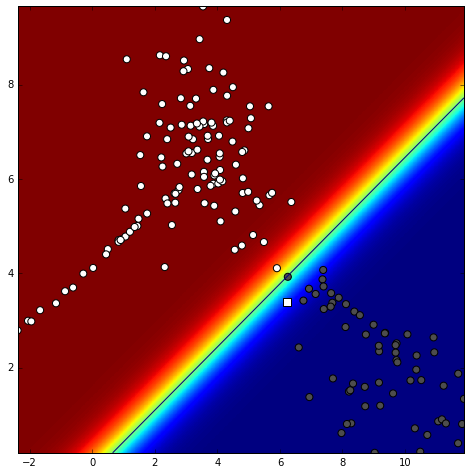

In [4]:
from tf_logreg import TFLogreg
C=2
#seed = np.random.randint(0,500000)
#print seed
np.random.seed(2612)
#306285
#423245
# layers = [2,10,10,2]
input_data, expected_output = sample_gmm_2d(6,C,30)

tfLog = TFLogreg(2,C)
# tfLog = TFDeep(layers,param_delta=0.01,param_lambda=0.01,activation=tf.nn.relu,std=0.1)
tfLog.train(input_data,labels_to_one_hot(expected_output,C),30000,print_every=2500)
decfun = predict_c1_class_tf(input_data)

def predict_c1_class_tf(X):
    def classify(X):
        return tfLog.eval(X)[:,1]
    return classify

# evaluate the model on the train set
probs = tfLog.eval(input_data)

# recover the predicted classes Y
my_predictions = probs[:,1] >0.5
my_predictions = my_predictions.flatten()


# graph the decision surface
bbox=(np.min(input_data, axis=0), np.max(input_data, axis=0))

#axis limits of the graph
xmin, ymin = bbox[0]
xmax, ymax = bbox[1]
plt.figure(figsize=(8,8))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

possible_labels = np.array(range(C))
mat = get_confusion_matrix(my_predictions,expected_output,possible_labels,True)
accuracy, prec, rec = eval_perf_multi(mat)
AP_c0 = eval_AP(expected_output[probs[:,0].argsort()],0)
AP_c1 = eval_AP(expected_output[probs[:,1].argsort()],1)

print "accuracy"
print accuracy
print "precision"
print prec
print "recall"
print rec
print "AP_c0"
print AP_c0
print "AP_c1"
print AP_c1

graph_surface(decfun, bbox, offset=0.5)

# graph the data points
graph_data(input_data, expected_output, my_predictions)

# show the plot
plt.show()

Iteration = 0, Loss = [0.70502025]
Iteration = 50, Loss = [0.62744492]
Iteration = 100, Loss = [0.59570575]
Iteration = 150, Loss = [0.47935459]
Iteration = 200, Loss = [0.34284914]
Iteration = 250, Loss = [0.29255]
Iteration = 300, Loss = [0.28414586]
Iteration = 350, Loss = [0.27786928]
Iteration = 400, Loss = [0.27085367]
Iteration = 450, Loss = [0.2705133]
Iteration = 500, Loss = [0.26675421]
Iteration = 550, Loss = [0.27404723]
Iteration = 600, Loss = [0.2639581]
Iteration = 650, Loss = [0.26659006]
Iteration = 700, Loss = [0.25482309]
Iteration = 750, Loss = [0.26462236]
Early stopping on iteration = 750, training model restored from checkpoint with training loss = [0.26462236], validation loss = [0.27807957]
Restored model validation set loss = [0.27807957]
            0     1
     0[    58     2]
     1[     7   113]
accuracy
0.95
precision
[0.89230769230769236, 0.9826086956521739]
recall
[0.96666666666666667, 0.94166666666666665]
AP_c0
0.977354881881
AP_c1
0.994253357613


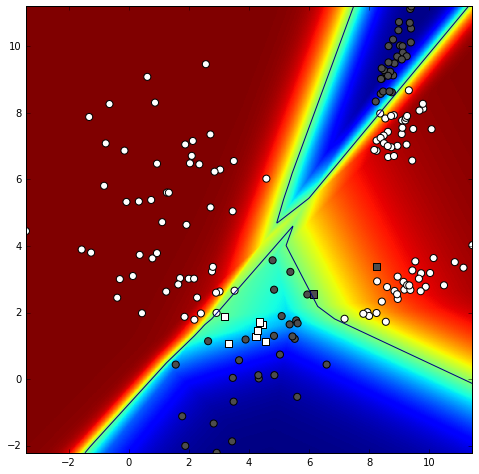

In [2]:
from tf_deep import TFDeep
C=2
np.random.seed(423245)
layers = [2,10,10,2]
input_data, expected_output = sample_gmm_2d(6,C,30)

tfDeep = TFDeep(layers,param_delta=0.01,param_lambda=0.01,activation=tf.nn.relu,std=0.1)
tfDeep.train(input_data,labels_to_one_hot(expected_output,C),10000,print_every=50,early_stop_after=50,minibatch=20)

def predict_c1_class_tf(X):
    def classify(X):
        return tfDeep.eval(X)[:,1]
    return classify


decfun = predict_c1_class_tf(input_data)

# evaluate the model on the train set
probs = tfDeep.eval(input_data)

# recover the predicted classes Y
my_predictions = probs[:,1] >0.5
my_predictions = my_predictions.flatten()


# graph the decision surface
bbox=(np.min(input_data, axis=0), np.max(input_data, axis=0))

#axis limits of the graph
xmin, ymin = bbox[0]
xmax, ymax = bbox[1]
plt.figure(figsize=(8,8))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

possible_labels = np.array(range(C))
mat = get_confusion_matrix(my_predictions,expected_output,possible_labels,True)
accuracy, prec, rec = eval_perf_multi(mat)
AP_c0 = eval_AP(expected_output[probs[:,0].argsort()],0)
AP_c1 = eval_AP(expected_output[probs[:,1].argsort()],1)

print "accuracy"
print accuracy
print "precision"
print prec
print "recall"
print rec
print "AP_c0"
print AP_c0
print "AP_c1"
print AP_c1

graph_surface(decfun, bbox, offset=0.5)

# graph the data points
graph_data(input_data, expected_output, my_predictions)

# show the plot
plt.show()

            0     1
     0[    57     3]
     1[     1   119]
accuracy
0.977777777778
precision
[0.98275862068965514, 0.97540983606557374]
recall
[0.94999999999999996, 0.9916666666666667]
AP_c0
0.995968448068
AP_c1
0.998880493509


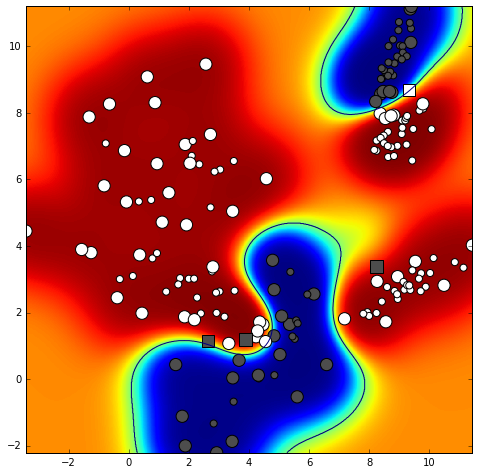

In [38]:
from ksvm_wrap import KSVMWrap
C=2
np.random.seed(423245)
input_data, expected_output = sample_gmm_2d(6,C,30)

SVM_Wrap = KSVMWrap(input_data,expected_output)

def predict_c1_class_tf(X):
    def classify(X):
        return SVM_Wrap.scores(X)[1][:,1]
    return classify

decfun = predict_c1_class_tf(input_data)

# evaluate the model on the train set
probs = SVM_Wrap.scores(input_data)[1]

# recover the predicted classes Y
my_predictions = probs[:,1] >0.5
my_predictions = my_predictions.flatten()


# graph the decision surface
bbox=(np.min(input_data, axis=0), np.max(input_data, axis=0))

#axis limits of the graph
xmin, ymin = bbox[0]
xmax, ymax = bbox[1]
plt.figure(figsize=(8,8))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

possible_labels = np.array(range(C))
mat = get_confusion_matrix(my_predictions,expected_output,possible_labels,True)
accuracy, prec, rec = eval_perf_multi(mat)
AP_c0 = eval_AP(expected_output[probs[:,0].argsort()],0)
AP_c1 = eval_AP(expected_output[probs[:,1].argsort()],1)

print "accuracy"
print accuracy
print "precision"
print prec
print "recall"
print rec
print "AP_c0"
print AP_c0
print "AP_c1"
print AP_c1

graph_surface(decfun, bbox, offset=0.5)

# graph the data points
graph_data(input_data, expected_output, my_predictions,special=SVM_Wrap.support())

# show the plot
plt.show()

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

def predict_c1_class_tf(X):
    def classify(X):
        return tfLog.eval(X)[:,1]
    return classify
#with tf.device("/gpu:0"):
C=2
layers = [784,10]

tfDeep = TFDeep(layers,param_delta=0.01,param_lambda=0.01,std=0.001,checkpoint_file="model-(784,10).ckpt")
tfDeep.train(mnist.train.images,mnist.train.labels,10000,print_every=100)
tfDeep.save()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration = 0, Loss = 2.303171
Iteration = 100, Loss = 1.562556
Iteration = 200, Loss = 1.212430
Iteration = 300, Loss = 1.027789
Iteration = 400, Loss = 0.917420
Iteration = 500, Loss = 0.844905
Iteration = 600, Loss = 0.793937
Iteration = 700, Loss = 0.756317
Iteration = 800, Loss = 0.727511
Iteration = 900, Loss = 0.704820
Iteration = 1000, Loss = 0.686538
Iteration = 1100, Loss = 0.671537
Iteration = 1200, Loss = 0.659041
Iteration = 1300, Loss = 0.648498
Iteration = 1400, Loss = 0.639505
Iteration = 1500, Loss = 0.631762
Iteration = 1600, Loss = 0.625041
Iteration = 1700, Loss = 0.619164
Iteration = 1800, Loss = 0.613992
Iteration = 1900, Loss = 0.609415
Iteration = 2000, Loss = 0.605342
Iteration = 2100, Loss = 0.601702
Iteration = 2200, Loss = 0.598435
Iteration = 2300, Loss = 0.595491
It

In [3]:
layers = [784,10]
tfDeep = TFDeep(layers,param_delta=0.01,param_lambda=0.01,std=0.001,checkpoint_file="model-(784,10).ckpt")
tfDeep.restore()

In [24]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
probs = tfDeep.eval(mnist.train.images)
# recover the predicted classes Y
my_predictions = probs[:,1] >0.5
my_predictions = my_predictions.flatten()


# graph the decision surface
bbox=(np.min(input_data, axis=0), np.max(input_data, axis=0))

#axis limits of the graph
C=10
possible_labels = np.array(range(C))
mat = get_confusion_matrix(np.argmax(probs,axis=1),np.argmax(mnist.train.labels,axis=1),possible_labels,True,format_length=10)
accuracy, prec, rec = eval_perf_multi(mat)
# AP_c0 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,0].argsort()],0)
# AP_c1 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,1].argsort()],1)
# AP_c2 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,2].argsort()],2)
# AP_c3 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,3].argsort()],3)
# AP_c4 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,4].argsort()],4)
# AP_c5 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,5].argsort()],5)
# AP_c6 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,6].argsort()],6)
# AP_c7 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,7].argsort()],7)
# AP_c8 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,8].argsort()],8)
# AP_c9 = eval_AP(np.argmax(mnist.train.labels,axis=1)[probs[:,9].argsort()],9)
print
print "Accuracy"
print accuracy
print
print "Precision"
print prec
print
print "Recall"
print rec
print
print "Average Precision"
print "[0]-%.2f, [1]-%.2f, [2]-%.2f, [3]-%.2f, [4]-%.2f, [5]-%.2f, [6]-%.2f, [7]-%.2f, [8]-%.2f, [9]-%.2f" %(AP_c0,AP_c1,AP_c2,AP_c3,AP_c4,AP_c5,AP_c6,AP_c7,AP_c8,AP_c9)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
                    0         1         2         3         4         5         6         7         8         9
         0[      5232         0        24        15        13        35        52         3        62         8]
         1[         1      5986        26        27         5        37         9        13        66         9]
         2[        45        85      4696        86       122        16       112       111       160        37]
         3[        28        43       128      4902         7       215        42        69       137        67]
         4[        10        37        29         4      4838         6        59        13        46       265]
         5[        98        65        38       209        79      4085       111        33       184        85]
         6[     

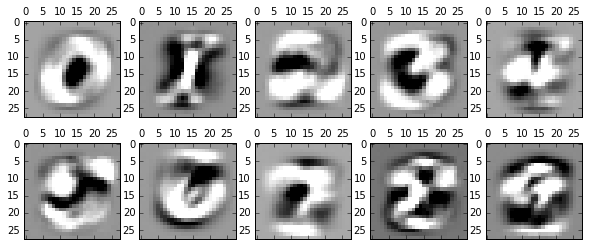

In [34]:
len(tfDeep.sess.run(tfDeep.last_layer_w)[:,0])
f, axes = plt.subplots(2,5)
axes = axes.flatten()

f.set_figheight(4)
f.set_figwidth(10)

for i in range(10):
    vmin, vmax = tfDeep.sess.run(tfDeep.last_layer_w)[:,i].min(),tfDeep.sess.run(tfDeep.last_layer_w)[:,0].max()
    axes[i].matshow(tfDeep.sess.run(tfDeep.last_layer_w)[:,i].reshape(28,28),cmap=plt.cm.gray, vmin=0.5 * vmin, vmax = 0.5 * vmax)
plt.show()